In [199]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cnt
from scipy.signal import savgol_filter
from decimal import Decimal

In [200]:
data = np.loadtxt('data/Super/MessungQHE.dat', delimiter='\t', skiprows=26, usecols=[2,10, 11])

data = data[data[:, 0].argsort()]

B = data[:,0]
R_h = data[:, 1] * 30
R_long = data[:, 2]

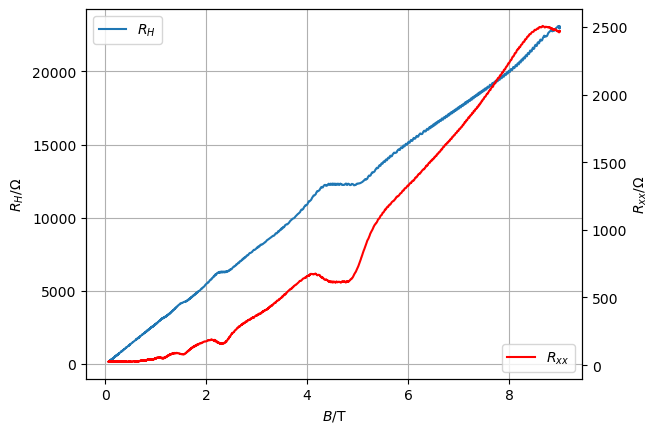

In [445]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(B, R_h, label='$R_H$')
ax2.plot(B, R_long, label='$R_{xx}$', c='r')
ax2.set(ylabel='$R_{xx} / \mathrm{\Omega}$')
ax.set(ylabel='$R_{H} / \mathrm{\Omega}$', xlabel="$B / \\mathrm{T}$")
ax.legend(loc=2)
ax2.legend(loc=4)
ax.grid()
fig.savefig('out/raw_data')

In [202]:
def convert2latex(number, precision=3):
    sci_str = f"{number:.{precision}e}"
    base, exponent = sci_str.split("e")
    exponent = int(exponent)
    return f"{base} \\cdot 10^{{{exponent}}}"

n_s = 2.235e+15 m^-2


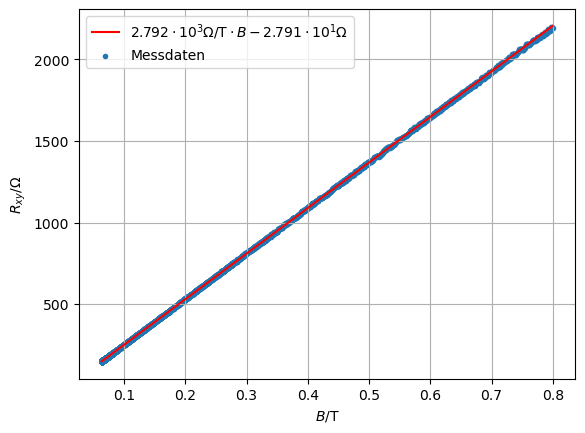

In [203]:
##Flächenladungsdichte
fig2, ax2 = plt.subplots()
i_max = np.argmin(np.abs(B - 0.8))

slope, intercept = np.polyfit(B[:i_max], R_h[:i_max], 1)

# Zeichnen der Regressionslinie
ax2.plot(B[:i_max], slope*B[:i_max] + intercept,
         label=f'${convert2latex(slope)} \\mathrm{{\Omega/T}} \cdot B  {convert2latex(intercept)} \\mathrm{{\Omega}}$', color='r')


ax2.scatter(B[:i_max], R_h[:i_max],marker='.', label='Messdaten')
ax2.grid()
ax2.set(xlabel="$B / \\mathrm{{T}}$", ylabel="$R_{xy} / \\mathrm{{\\Omega}}$")
ax2.legend()
print(f'n_s = {1/(cnt.e * slope):.3e} m^-2')

fig2.savefig('out/flaechenladung')

In [249]:
def get_plateaus(flat_parts, gap_tolerance):
    in_plateau = False
    gap_count = 0
    plateau_starts = []
    plateau_ends = []
    for i, is_flat in enumerate(flat_parts):
        if is_flat:
            if not in_plateau:
                in_plateau = True
                plateau_starts.append(i)
            gap_count = 0
        else:
            if in_plateau:
                if gap_count < gap_tolerance:
                    gap_count += 1
                else:
                    in_plateau = False
                    plateau_ends.append(i - gap_count)
    if in_plateau:
        plateau_ends.append(i)
    return plateau_starts, plateau_ends


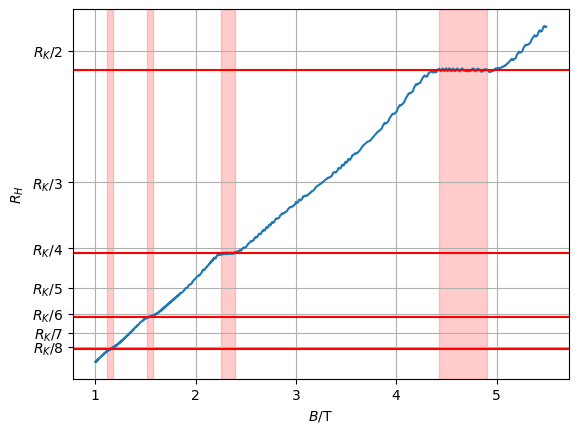

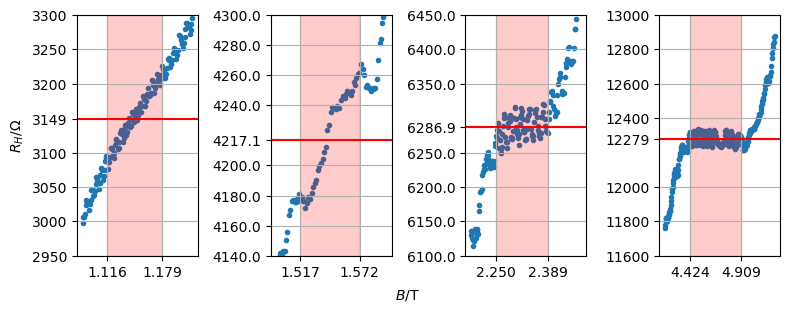

In [328]:
Bmin, Bmax = [1, 5.5]
Bmin_i, Bmax_i = (np.argmin(np.abs(B - Bmin)), np.argmin(np.abs(B - Bmax)))
R_h_red = R_h[Bmin_i:Bmax_i]
B_red = B[Bmin_i:Bmax_i]

##Hall Platos
R_h_smooth = savgol_filter(R_h_red, 150, 2)
dR_h = np.gradient(R_h_smooth)
flat_parts = np.isclose(dR_h, 0, atol=1.9)

rs = lambda i : cnt.h / (cnt.e ** 2 * i)

fig3, ax3 = plt.subplots()
ax3.plot(B_red, R_h_red)



plateau_starts, plateau_ends = get_plateaus(flat_parts, gap_tolerance=10)

# Durchschnittsberechnung für jedes Plateau
for start, end in zip(plateau_starts, plateau_ends):
    ax3.axvspan(B_red[start], B_red[end], alpha=.2, color='red')
    mean = np.mean( R_h_red[start:end])
    ax3.axhline(mean, c='r')

i_s = range(2,9)
ax3.set(
    yticks=[rs(i) for i in i_s],
    yticklabels=[f'$R_K / {i}$' for i in i_s],
    xlabel="$B / \mathrm{T}$",
    ylabel="$R_H$")
ax3.grid()

fig3.savefig('out/overview_qhe')

fig4, ax4s = plt.subplots(1, len(plateau_starts), figsize=(8, 3)) #sharey=True)

width= 0.5
i_map = [8,6,4,2]
for i, (start, end) in enumerate(zip(plateau_starts, plateau_ends)):
    s, e = start - int((end - start) * width), end + int((end - start) * width)
    ax4s[i].scatter(B_red[s:e], R_h_red[s:e], marker='.')
    ax4s[i].axvspan(B_red[start], B_red[end], alpha=.2, color='red')
    mean = np.mean( R_h_red[start:end])
    ax4s[i].axhline(mean, c='red')
    ax4s[i].grid()
    r_height = (R_h_red[e] - R_h_red[s])/2

    ax4s[i].set(xticks=np.around(B_red[[start,end]], decimals=3), ylim=[mean - r_height, mean + r_height])

    yticks = ax4s[i].get_yticks()
    closest_ytick = yticks[np.abs(yticks - mean).argmin()]
    new_yticks = [mean if tick == closest_ytick else tick for tick in yticks]
    ax4s[i].set_yticks(new_yticks)

ax4s[0].set(ylabel="$R_H / \\mathrm{{\Omega}}$")
fig4.text(0.5, 0.0, '$B / \\mathrm{T}$', va='center')
fig4.tight_layout()
fig4.savefig('out/details_qhe')

2.142e+15


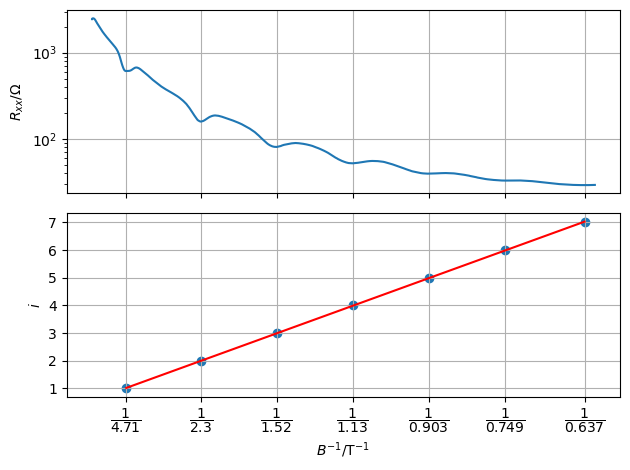

In [432]:
#shubnikov-de-hassOszillationen

left, right = (np.argmin(np.abs(1/B - 1.6))), (np.argmin(np.abs(1/B - 0.01)))
B_osc = B[left:right]
R_long_osc = R_long[left:right]
R_long_smooth = savgol_filter(R_long_osc, 150, 2)


fig5, (ax5, ax6) = plt.subplots(2, sharex=True)
#ax5.plot(1/B_osc, R_long_osc)
ax5.plot(1/B_osc, R_long_smooth)
ax5.set(yscale='log')
from scipy.signal import argrelextrema

# find indices of local minima
minima_indices = argrelextrema(R_long_smooth, np.less, order=30)[0]

ax5.set(xticks=1/B_osc[minima_indices],
        xticklabels=[f'$\\dfrac{{1}}{{{b:.3}}}$' for b in B_osc[minima_indices]],
         ylabel='$R_{xx} / \\mathrm{\\Omega}$')

ax5.grid()
cnter = np.arange(len(minima_indices),  0, -1)
ax6.scatter( 1/B_osc[minima_indices], cnter)
ax6.set(xlabel='$B^{-1} / \mathrm{T^{-1}}$', ylabel="$i$", yticks=cnter)
ax6.grid()

x = 1/B_osc[minima_indices]
y = cnter
coefficients = np.polyfit(x, y, 1)  # 1 is the degree of the polynomial (linear)
slope, intercept = coefficients

# plot the regression line
x_values = np.linspace(min(x), max(x), 100)
y_values = slope * x_values + intercept
ax6.plot(x_values, y_values, color='red')

delta = 1/slope
print(f'{2 * cnt.e / cnt.h * slope:.3e}')

fig5.tight_layout()
fig5.savefig('out/shubnikov-de-hass')